# Analysis of LSTM model
This notebook includes code to analyze LSTM model predictions for the national test dataset. The first section generates performance statistics and plots of individual years for a given LSTM model. The second section generates a visualization of the ensemble of models and its training data, the third section plots performance statistics as a heatmap, and the final section analyzes feature importance. 

In [1]:
# preliminaries
import os
os.environ["http_proxy"] = "http://verde:8080"
os.environ["https_proxy"] = "http://verde:8080"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from captum.attr import IntegratedGradients
import pickle
import hf_hydrodata as hf
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as patches

from _data import *

# Statistics

In [ ]:
## VIEW STATISTICS FOR GIVEN MODEL ##
run = 'l6_600'
statistics = pd.read_csv('Data/LSTM_output/'+run+'_statistics.txt',sep=' ',header=None)
statistics.columns = ['rmse','normal rmse','nse','r2','spearman_rho','delta peak','normal delta peak','abs delta peak','normal abs delta peak',
                      'delta days','abs delta days']
#statistics.columns = ['rmse','normal rmse','nse','r2','spearman_rho','delta peak','normal delta peak','delta days']

# drop years 666 and 65 because of erroneous/missing meteorologial data
print('Medians:')
print(f"RMSE: {np.median(statistics.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.median(statistics.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.median(statistics.drop([666, 65])['nse']):.2f}")
print(f"R2: {np.median(statistics.drop([666, 65])['r2']):.2f}")
print(f"Spearman's rho: {np.median(statistics.drop([666, 65])['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(statistics.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(statistics.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(statistics.drop([666, 65])['abs delta peak']):.2f}")
print(f"normal absolute delta peak SWE: {np.median(statistics.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(statistics.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.median(statistics.drop([666, 65])['abs delta days']):.2f}")

print('\nMeans:')
print(f"RMSE: {np.mean(statistics.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.mean(statistics.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.mean(statistics.drop([666, 65])['nse']):.2f}")
print(f"R2: {np.mean(statistics.drop([666, 65])['r2']):.2f}")
print(f"Spearman's rho: {np.mean(statistics.drop([666, 65])['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(statistics.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(statistics.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.mean(statistics.drop([666, 65])['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.mean(statistics.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.mean(statistics.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.mean(statistics.drop([666, 65])['abs delta days']):.2f}")

# standard deviations of normal values
print('\nStandard deviations:')
print(f"normal RMSE: {np.std(statistics.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.std(statistics.drop([666, 65])['nse']):.2f}")
print(f"normal delta peak SWE: {np.std(statistics.drop([666, 65])['normal delta peak']):.2f}")
print(f"normal absolute delta peak SWE: {np.std(statistics.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"absolute delta days: {np.std(statistics.drop([666, 65])['abs delta days']):.2f}")

In [ ]:
## PLOT LSTM PREDICTIONS FOR SINGLE YEAR ##
run = 'l6_500'

data_test = pd.read_csv('/home/mcburns/national_lstm/national_test_years.txt', sep=' ',header=None)
data_test.columns = ['site_id',	'year',	'train']

# run LSTM
with open('/home/mcburns/national_lstm/output/'+run+'_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe = l_normalize[0]
test_swe_tensors = torch.load('output/'+run + '_test_swe.pt')
test_non_swe_tensors = torch.load('output/'+run + '_test_non_swe.pt')
#test_swe_tensors, test_non_swe_tensors, test_sites, test_years = create_dataset(test_swe, test_non_swe, l_normalize)
ev_lstm = torch.load('output/'+run+'_lstm.pt', map_location = DEVICE)


i_n = 717
swe_pred, swe_actual = run_lstm(run, i_n)
plt.plot(swe_pred, label='lstm')
plt.plot(swe_actual, label='snotel')
plt.title(data_test['site_id'][i_n] + ' : ' + str(data_test['year'][i_n]))
plt.legend()

# Visualization of models

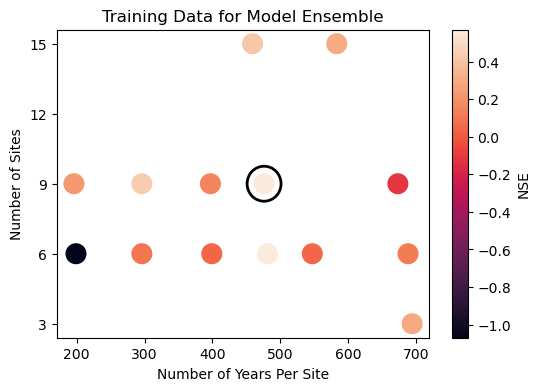

In [52]:
## PLOT ENSEMBLE OF MODELS RUN ##
model_ensemble = pd.DataFrame({
    'Model Name': ['l6_200', 'l9_200', 'l6_300','l9_300','l6_400','l9_400','l6_500','l9_500','l15_500','l6_600','full_3','full_6','full_9','full_15'],
    'sites': [199, 196, 296, 296, 399, 397, 481, 476, 459, 547, 694, 688, 673, 583],
    'years': [6, 9, 6, 9, 6, 9, 6, 9, 15, 6, 3, 6, 9, 15],
    'NSE':[-1.07, 0.23, 0.1, 0.44, 0.05, 0.15, 0.57, 0.56, 0.41, 0.05, 0.29, 0.12, -0.12, 0.3],
    'RMSE': [77.93, 69.72, 72.73, 65.2, 68.45, 64.81, 63.89, 64.05, 60.73, 66.72, 64.88, 64.14, 66.56, 61.49],
    'Median NSE': [0.81, 0.83, 0.81, 0.84, 0.86, 0.85, 0.84, 0.87, 0.85, 0, 0, 0, 0]})  # these are not correct - do not plot with them

# plot
fig, ax = plt.subplots(figsize=(6, 4))
scatter = plt.scatter(x=model_ensemble['sites'], y=model_ensemble['years'], c=model_ensemble['NSE'], cmap='rocket', s=200)
circle = patches.Ellipse((476, 9), width=50, height=1.5, color='black', fill=False, linewidth=2) 
ax.add_patch(circle)

plt.xlabel('Number of Years Per Site')
plt.ylabel('Number of Sites')
plt.title('Training Data for Model Ensemble')
plt.yticks([3, 6, 9, 12, 15])
cbar = plt.colorbar(scatter)
cbar.set_label('NSE')

# Model statistics

[Text(0.5, 1.0, 'Best-Performing Models'),
 Text(0.5, 23.52222222222222, 'Run Name')]

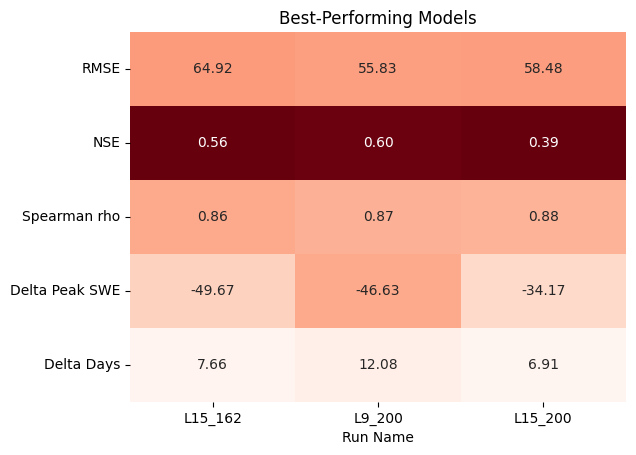

In [6]:
## HEATMAP FOR TOP THREE MODELS ##
models = ['l5_162','l3_200','l5_200']
total_statistics = get_model_metrics(models)

# adjust data
total_statistics = total_statistics.set_index('run name')
total_statistics_plot = total_statistics.drop(columns=['r2','rmse','delta peak','delta days'])
total_statistics = total_statistics.drop(columns=['r2','normal rmse','normal delta peak','normal delta days'])

# adjust colors
total_statistics_plot['nse'] = 1-total_statistics_plot['nse']
total_statistics_plot['spearman_rho'] = 1-total_statistics_plot['spearman_rho']
total_statistics_plot = np.abs(total_statistics_plot)
total_statistics_plot = total_statistics_plot.transpose()
total_statistics = total_statistics.transpose()

# plot
ax = sns.heatmap(total_statistics_plot, annot=total_statistics, fmt=".2f", cmap='Reds', vmax=0.4, cbar=False,
                 yticklabels = ['RMSE','NSE','Spearman rho','Delta Peak SWE','Delta Days'], xticklabels=['L15_162','L9_200','L15_200'])
ax.set(title='Best-Performing Models', xlabel='Run Name')


# Feature importance

Text(0, 0.5, 'Absolute Feature Importance')

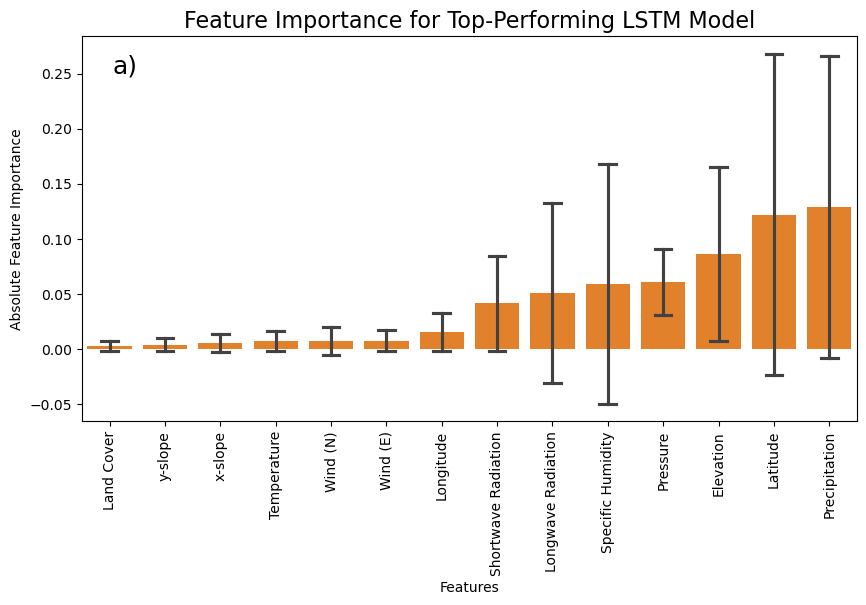

In [31]:
## BAR PLOT ##
feature_names = ['Precipitation','Temperature','Elevation','Latitude','Longitude','Shortwave Radiation','Longwave Radiation','Wind (E)','Wind (N)',
                 'Pressure','Specific Humidity','Land Cover','x-slope','y-slope']

feature_importance = pd.read_csv('Data/LSTM_output/l9_500_features.txt', sep=' ', header=None)
feature_importance = pd.DataFrame(feature_importance).abs()
feature_importance.columns = feature_names

# try scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(feature_importance.values.flatten().reshape(-1, 1))
feature_importance_scaled = pd.DataFrame(scaled_data.reshape(feature_importance.shape), columns=feature_importance.columns)

summary_feature_importance = pd.DataFrame({'feature':feature_names ,'means': np.mean(feature_importance, axis=0), 
                                           'std dev': np.std(feature_importance, axis=0)})
summary_feature_importance.sort_values(by='means', inplace=True) 

feature_importance_plot = feature_importance_scaled.melt(var_name='Features', value_name='Importance')

# barplot
plt.figure(figsize=(10,5))
#plt.bar(summary_feature_importance['feature'], summary_feature_importance['means'], yerr=summary_feature_importance['std dev'], color='#ff7f0e', capsize=5)
sns.barplot(x='Features', y='Importance', data=feature_importance_plot, errorbar='sd', order=summary_feature_importance['feature'], 
            capsize=0.3, color='#ff7f0e')
plt.text(0.05, 0.25, 'a)', fontsize=18)
#plt.yticks([])
plt.xticks(rotation=90)
plt.title('Feature Importance for Top-Performing LSTM Model', size=16)
plt.ylabel('Absolute Feature Importance')

Text(0.05, 0.12, 'a)')

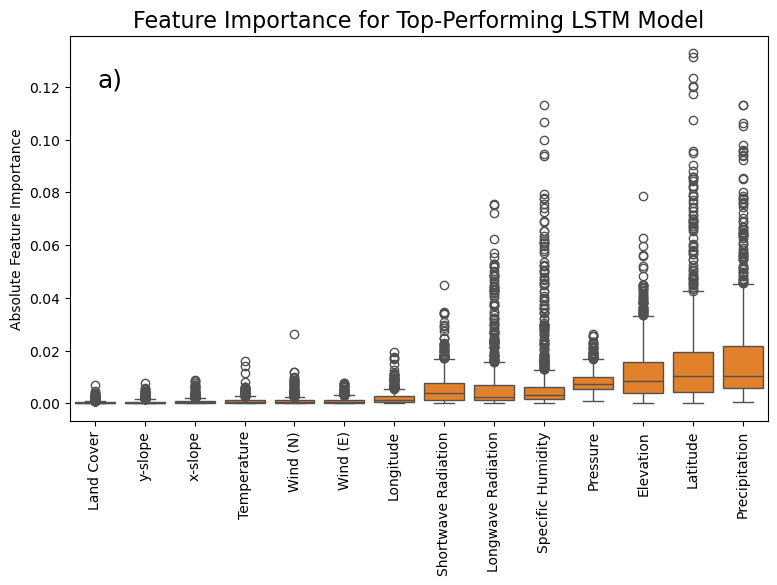

In [75]:
## BOX PLOT ##
feature_importance_plot = feature_importance.melt(var_name='Features', value_name='Importance')

# boxplot
plt.figure(figsize=(9,5))
sns.boxplot(x='Features', y='Importance', data=feature_importance_plot, order=summary_feature_importance['feature'], color='#ff7f0e')
#plt.yticks([])
plt.xticks(rotation=90)
plt.title('Feature Importance for Top-Performing LSTM Model', size=16)
plt.ylabel('Absolute Feature Importance')
plt.xlabel('')
plt.text(0.05, 0.12, 'a)', fontsize=18)

Text(0.03, 0.025, 'b)')

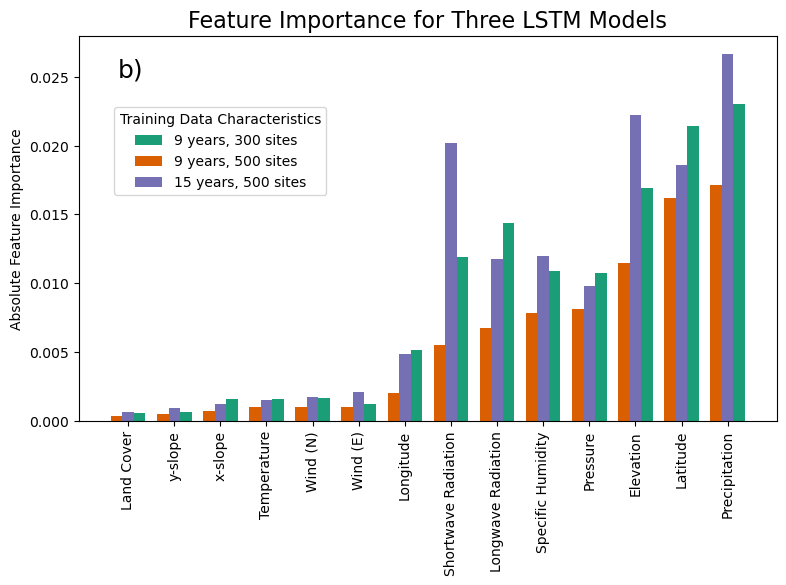

In [76]:
## COMPARE MULTIPLE MODELS ##
feature_importance_1 = pd.DataFrame(abs(pd.read_csv('Data/LSTM_output/l9_500_features.txt', sep=' ', header=None)))
feature_importance_2 = pd.DataFrame(abs(pd.read_csv('Data/LSTM_output/l15_500_features.txt', sep=' ', header=None)))
feature_importance_3 = pd.DataFrame(abs(pd.read_csv('Data/LSTM_output/l9_300_features.txt', sep=' ', header=None)))
feature_importance_1.columns = feature_names
feature_importance_2.columns = feature_names
feature_importance_3.columns = feature_names

feature_importance_1 = feature_importance_1.reindex(columns=summary_feature_importance['feature'])
feature_importance_2 = feature_importance_2.reindex(columns=summary_feature_importance['feature'])
feature_importance_3 = feature_importance_3.reindex(columns=summary_feature_importance['feature'])

# plot
sns.set_palette('Dark2')
width = 0.5
x_pos = np.arange(0, 2*len(feature_names), 2)
plt.figure(figsize=(9,5))
plt.bar(x_pos+2*width, np.mean(feature_importance_3, axis=0), width, label='9 years, 300 sites')
plt.bar(x_pos, np.mean(feature_importance_1, axis=0), width, label='9 years, 500 sites')
plt.bar(x_pos+width, np.mean(feature_importance_2, axis=0), width, label='15 years, 500 sites')
#plt.xticks(x_pos, feature_names, wrap=True)
plt.xticks(x_pos+width, summary_feature_importance['feature'], rotation=90)
plt.legend(loc='center left', title='Training Data Characteristics', bbox_to_anchor=(0.04, 0.7))
plt.title('Feature Importance for Three LSTM Models', size=16)
plt.ylabel('Absolute Feature Importance')
plt.text(0.03, 0.025, 'b)', fontsize=18)

In [70]:
## SAVE FEATURE IMPORTANCE AS CSV ##
models = ['l10_162','l3_162']

for run_name in models:
    lstm = torch.load('output/'+run_name+'_lstm.pt', map_location = DEVICE)
    train_swe = torch.load('output/'+run_name + '_train_swe.pt')
    train_non_swe = torch.load('output/'+run_name + '_train_non_swe.pt')
    test_swe = torch.load('output/'+run_name + '_test_swe.pt')
    test_non_swe = torch.load('output/'+run_name + '_test_non_swe.pt')
    with open('output/'+run_name + '_normalize.pkl', 'rb') as file:  
        l_normalize = pickle.load(file)
    scaler_swe = l_normalize[0]
    test_metadata = pd.read_csv('output/'+run_name + '_test_metadata.csv', sep=' ')

    statistics, feature_importance = analyze_results(lstm, test_metadata, test_swe, test_non_swe, scaler_swe, False)
    feature_importance = pd.DataFrame(feature_importance)

    feature_importance.to_csv('output/'+run_name+'_features.txt',sep=' ',header=None, index=False, index_label=False)

## FEATURE IMPORTANCE ##
#feature_names = ['precip','temp','elevation','latitude','longitude','DSWR','DLWR','wind (E)','wind (N)','pressure','q','land_cover','slope_x','slope_y']
#visualize_importances(feature_names, np.mean(feature_importance, axis=0))

## Feature importance by site location

In [32]:
## GET DATA ##
test_sites = pd.read_csv('national_test_sites.txt', sep=' ', header=None)
test_sites.columns = ['site_id', 'site_name', 'site_type', 'agency', 'state','first_date_data_available', 'last_date_data_available', 'record_count',
                     'latitude', 'longitude', 'bins','first_wy_date', 'last_wy_date']
test_metadata = pd.read_csv('Data/LSTM_output/test_metadata.csv', sep=' ',header=None)
test_metadata.columns = ['site_id','year','train','latitude','longitude','elevation','land_cover','slope_x','slope_y']

complete_feature_importance = pd.concat([test_metadata, feature_importance], axis=1).groupby('site_id').mean().reset_index()
complete_feature_importance['most important feature'] = complete_feature_importance[feature_names].idxmax(axis=1)

In [41]:
len(complete_feature_importance[complete_feature_importance['most important feature']=='Latitude'])

34

/tmp/ipykernel_3409179/3961336571.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Paired', num_categories)


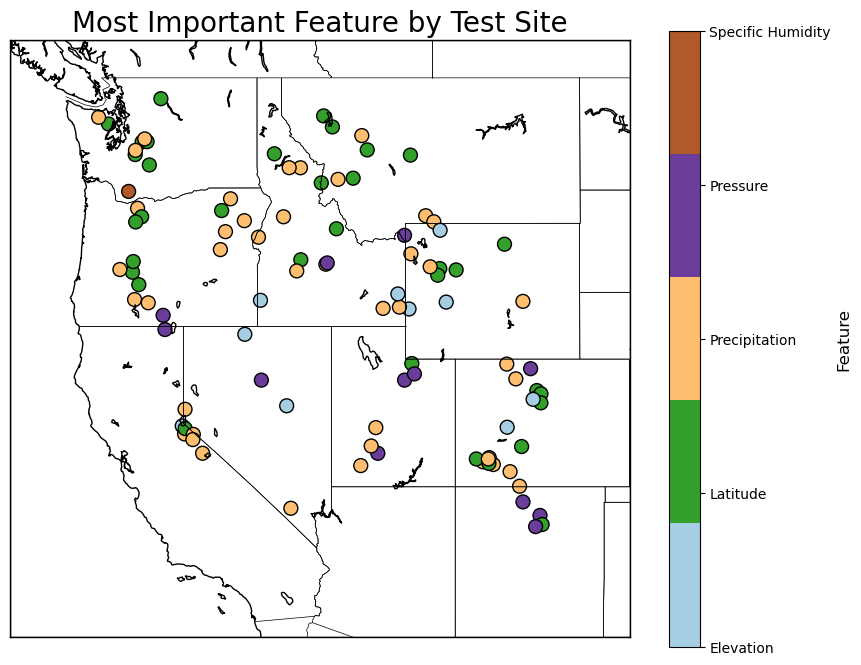

In [161]:
## MAP ##
label_encoder = LabelEncoder()
complete_feature_importance['most important feature ENCODED'] = label_encoder.fit_transform(complete_feature_importance['most important feature'])
categories = label_encoder.classes_
num_categories = len(categories)
cmap = mpl.cm.get_cmap('Paired', num_categories)

fig, axes = plt.subplots(figsize=(10, 8))
map = Basemap(projection='merc', llcrnrlon=-127,llcrnrlat=32,urcrnrlon=-102,urcrnrlat=50, resolution = 'i')
x, y = map(complete_feature_importance['longitude'], complete_feature_importance['latitude'])
sc = map.scatter(x, y, c=complete_feature_importance['most important feature ENCODED'], marker='o', s=100, edgecolor='k', cmap=cmap)
map.drawmapboundary()
map.drawcountries()
map.drawcoastlines()
map.drawstates()
plt.title('Most Important Feature by Test Site', size=20)

cbar = plt.colorbar(sc, ax=axes, orientation='vertical')
cbar.set_ticks(np.arange(num_categories))  # Set ticks for each category
cbar.set_ticklabels(categories)  # Set tick labels to the actual category names
cbar.set_label('Feature', fontsize=12)